In [1]:
import top_k
import numpy as np
import pandas as pd

# Namaak benade 2018

In [ ]:
# using project costs and utils from benade 2018
P = 10
budget = 65

project_prizes= {0:10, 1:20, 2:3, 3:8, 4:5, 5:5, 6:10, 7:10, 8:30, 9:25}
possible_sets = top_k.get_possible_sets(project_prizes, budget)

In [ ]:
N = 720
epsilon = 15

base_util = np.asarray([5.8, 2.3, 29.3, 9.5, 14.8, 9.4, 5.4, 14.9, 6.7, 1.9])
utilities = top_k.make_voter_utils(base_util, epsilon, N)

In [ ]:
max_set = top_k.max_utility(possible_sets, utilities)


In [ ]:
for k in range(1, P):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, utilities, P)
        print(votes)
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, project_prizes)
        dist_score = top_k.calc_dist_score(winners, max_set, utilities)

#         print("util", util_score)
#         print("egal", egal_score)
#         print("comp", comp_score)
#         print("dist", dist_score)

In [ ]:
df = pd.read_csv("results/results_P10_ep15_N720_B65_min10_max25_L100.csv")

In [ ]:
from collections import Counter
from matplotlib import pyplot as plt

winners = []
for i, row in df.iterrows():
    win = []
    for i in range(1,10):
        get = "k_" + str(i) + "_winners"
        win.append(int(row[get]))
    winners.append(win)
    
winner_sets = []
for i, result in enumerate(winners):
    winner_sets.append(len(set(result)))
    
c = Counter(winner_sets)
plt.bar(list(c.keys()), c.values())
plt.xlabel("Different winning sets")
plt.ylabel("Runs")
plt.show()

# Epistemic accuracy

In [ ]:
from collections import defaultdict
from sklearn.preprocessing import normalize


def epistemic_topk(probs, k, N):
    votes = []
    projects = list(range(len(probs)))
    # Create noisy prob vectors for voters
    probs = np.tile(probs, (N,1))
    noise = np.random.normal(0.07, 0.05, (N, len(projects)))
    probs += noise
    # Set all negative probs to positive number and 
    probs[probs < 0] = 0.0001
    probs = normalize(probs, "l1", axis=1)
    # Every voters uses prob distr to vote
    for i in range(N):
        vote = np.random.choice(projects, k, replace=False, p=probs[i])
        votes += list(vote)
    return Counter(votes)


In [ ]:
P = 10 
epsilon = 10
N = 500
budget = 40
min_prize = 5
max_prize = 25

In [ ]:
values = top_k.make_base_util(P)
probs = values / np.sum(values)
prizes = top_k.make_projects(min_prize, max_prize, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
best_set = top_k.best_outcome(values, possible_sets)

In [ ]:
utilities = top_k.make_voter_utils(values, epsilon, N)


In [ ]:
for k in range(1, P):
    print("---------k------------", k)
    # calculate scores for all projects
    votes = epistemic_topk(probs, k,  N)
    print(votes)
    
    # determine the winning projects
    winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
    # Epistemic accuracy
    print("win:", list(winners), "--best",  best_set[0])
    correct = 0
    for alt in list(winners):
        if alt in best_set[0]:
            correct += 1
    
    acc = correct/len(best_set[0])
    print(acc)
                


# Different base utils

In [ ]:
P = 10
epsilon = 10
N = 500
budget = 40
min_prize = 5
max_prize = 15

In [ ]:
prizes = top_k.make_projects(min_prize, max_prize, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
# best_set = top_k.best_outcome(values, possible_sets)
max_set, max_total_util = top_k.max_utility(possible_sets, utilities)

In [ ]:
# Create different base utilities 
base_util, vote_util = [], []
for i in range(P):
    util = top_k.make_base_util(P)
    base_util.append(util)    
    utilities = top_k.make_voter_utils(util, epsilon, int(N/5))
    vote_util.append(utilities)
voter_utilities = np.vstack(vote_util)

In [ ]:
util_scores = []
egal_scores = []
comp_scores = []
dist_scores = []


for k in range(1, P+1):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, voter_utilities, P)
        print(f"votes: {votes}")
        
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, prizes, budget)
        print(winners)
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, prizes)
        dist_score = max_total_util / util_score

        print("util", util_score)
        print("egal", egal_score)
        print("comp", comp_score)
        print("dist", dist_score)
        
        util_scores.append(util_score)
        egal_scores.append(egal_score)
        comp_scores.append(comp_score)
        dist_scores.append(dist_score)

In [ ]:
from matplotlib import pyplot as plt

def plot(name, scores):
    x = range(1, P+1)
    plt.bar(x, scores)

    plt.title(name, fontsize=20)
    plt.xticks(range(1,10))

    plt.xlabel("k-value", fontsize=15)
    plt.ylabel("score", fontsize=15)
    plt.show()

In [ ]:
plot("util", util_scores)
plot("egal", egal_scores)
plot("comp", comp_scores)
plot("dist", dist_scores)

# Borda base util

In [7]:
P = 10
epsilon = 5
N = 500
budget = 30
min_prize = 5
max_prize = 10

In [8]:
def normal_prizes(min_prize, max_prize, sd, P):
    prizes = {}
    mid = (min_prize+sd)
    for i in range(P):
        prize = np.random.normal(mid, sd)
        prizes[i] = int(max(prize, min_prize))
    return prizes

In [9]:
# Create utilities
base_util = top_k.make_base_util(P)
base_util[0] = 30
base_util[1:] = 2
print(base_util)
utilities = top_k.make_voter_utils(base_util, epsilon, N)
print(utilities)
# Prizes and possible sets
prizes = top_k.make_projects(min_prize, max_prize, P)
# prizes = normal_prizes(min_prize, max_prize, 7, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
max_set, max_total_util = top_k.max_utility(possible_sets, utilities)


[30  2  2  2  2  2  2  2  2  2]
[[0.3480197  0.05540443 0.11822761 ... 0.         0.00131553 0.17003174]
 [0.28649328 0.12294893 0.         ... 0.08370905 0.11446642 0.06002747]
 [0.30366397 0.15248277 0.03939487 ... 0.00434662 0.03038045 0.09069267]
 ...
 [0.26735769 0.09935194 0.12049732 ... 0.07167543 0.04972302 0.08713407]
 [0.46652331 0.15840734 0.02210057 ... 0.01023146 0.01786145 0.07081528]
 [0.44020182 0.03752783 0.075834   ... 0.03072128 0.12397367 0.16393964]]


In [10]:
util_scores = []
egal_scores = []
comp_scores = []
dist_scores = []


for k in range(1, P+1):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, utilities, P)
        print(f"votes: {votes}")
        
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, prizes, budget)
        print(winners)
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, prizes)
        dist_score = max_total_util / util_score

        print("util", util_score)
        print("egal", egal_score)
        print("comp", comp_score)
        print("dist", dist_score)
        
        util_scores.append(util_score)
        egal_scores.append(egal_score)
        comp_scores.append(comp_score)
        dist_scores.append(dist_score)

---------k------------ 1
votes: Counter({0: 500, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0})
{0, 1, 2, 3}
util 0.574815658331146
egal 0.35205105314293356
comp 13.096
dist 1.1295271689052806
---------k------------ 2
votes: Counter({0: 500, 1: 71, 8: 62, 9: 57, 3: 57, 4: 55, 5: 53, 2: 52, 6: 49, 7: 44})
{0, 1, 8, 9}
util 0.5809070654947583
egal 0.3741245929344509
comp 14.03
dist 1.1176829165336826
---------k------------ 3
votes: Counter({0: 500, 1: 127, 8: 125, 4: 115, 3: 112, 9: 107, 6: 107, 7: 104, 2: 103, 5: 100})
{0, 1, 4, 7, 8}
util 0.6474748335899012
egal 0.4489943434049336
comp 17.416
dist 1.0027724160294393
---------k------------ 4
votes: Counter({0: 500, 9: 174, 1: 174, 6: 169, 8: 166, 4: 165, 7: 165, 3: 164, 2: 162, 5: 161})
{0, 9, 1, 6}
util 0.5799575651765543
egal 0.3486818171313012
comp 13.192
dist 1.1195127750416527
---------k------------ 5
votes: Counter({0: 500, 1: 229, 9: 227, 6: 224, 3: 224, 7: 224, 8: 223, 4: 221, 2: 214, 5: 214})
{0, 1, 9, 6}
util 0.5799575

In [11]:
from matplotlib import pyplot as plt

def plot(name, scores):
    x = range(1, P+1)
    plt.bar(x, scores)

    plt.title(name, fontsize=20)
    plt.xticks(range(1,10))

    plt.xlabel("k-value", fontsize=15)
    plt.ylabel("score", fontsize=15)
    plt.show()

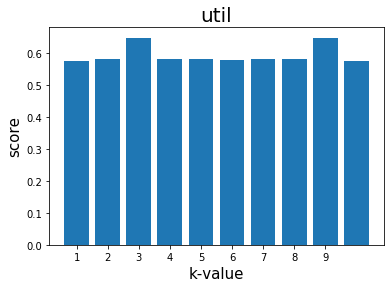

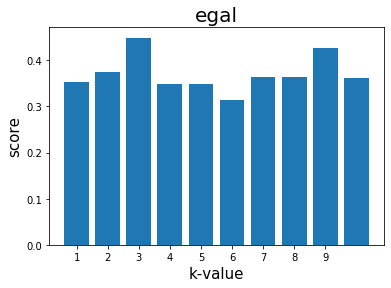

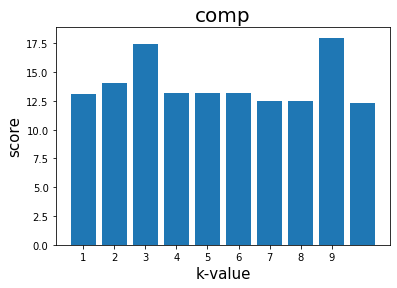

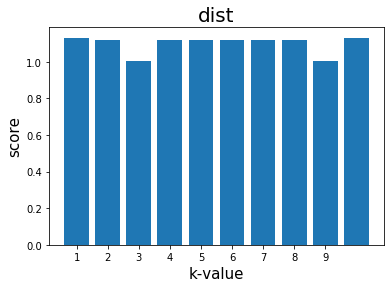

In [12]:
plot("util", util_scores)
plot("egal", egal_scores)
plot("comp", comp_scores)
plot("dist", dist_scores)